## 학습 목표 
- 딥러닝을 적용하여 핸드폰 인물 사진 모드(아웃포커스)를 따라 해 보자.
- 배경을 흐리게 하는 기술 : 얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus)

### 얕은 피사계 심도란?
-  “초점이 비행기 한 대에 맞춰져 있고, 나머지는 아웃포커싱 된 것" - 사진작가 Jeff Carlson
**빛을 많이 받을수록, 초점 거리가 길수록 피사계 심도가 얕아지는 효과를 얻게 됨**

#### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법
1. 배경이 있는 셀카를 촬영(배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리
3. 블러링(blurring) 기술로 배경을 흐리게 함
4. 피사체를 배경의 원래 위치에 합성

## 목차 
1. 사진 불러오기
2. 모델 불러오기
3. 세그멘테이션 다루기
4. 흐린 배경과 원본 영상 합성하기
5. 고양이 사진
6. 배경 합성하기


## 평가 기준
1. 인물모드 사진을 성공적으로 제작하였다.
    - 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
    - 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
    - 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

## 1. 사진 불러오기 

In [1]:
# 필요한 라이브러리 
import os
import urllib   #웹에서 데이터 다운로드 시 사용
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation  
from matplotlib import pyplot as plt

(560, 650, 3)


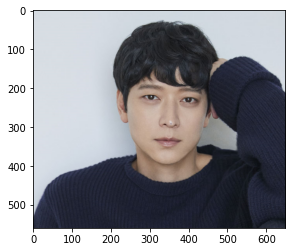

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/best.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 모델 불러오기 

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f46b9ed2220>)

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

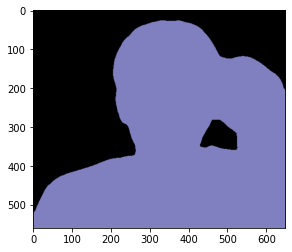

In [7]:
plt.imshow(output)
plt.show()

## 3. 세그멘테이션 다루기 

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# person이 15번째에 있음 
colormap[15]

array([192, 128, 128])

In [12]:
# output 이미지가 BGR 순서로 채널 배치
# RGB 순서로 바꿔주기
seg_color = (128,128,192)

### seg_color로만 이루어진 마스크 만들기 

(560, 650)


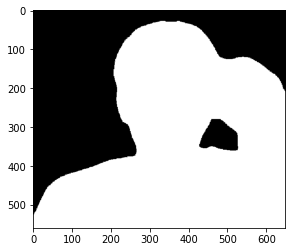

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

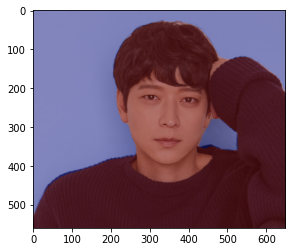

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기, blur() 함수를 이용

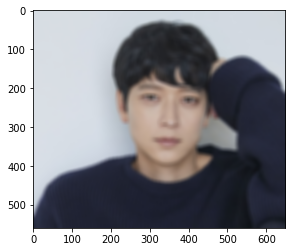

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 숫자가 올라가면 블러 효과가 커짐 
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- bitwise_not 함수를 이용하면 이미지가 반전
    - 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0
- 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있음
    - 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0 
    - **따라서 사람 부분이 0이 되면서 검정색으로 사라지게 됨**

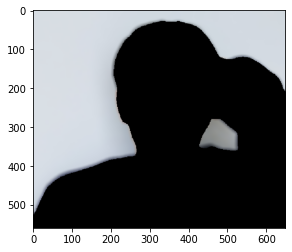

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 흐린 배경과 원본 영상 합성하기 
- 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용

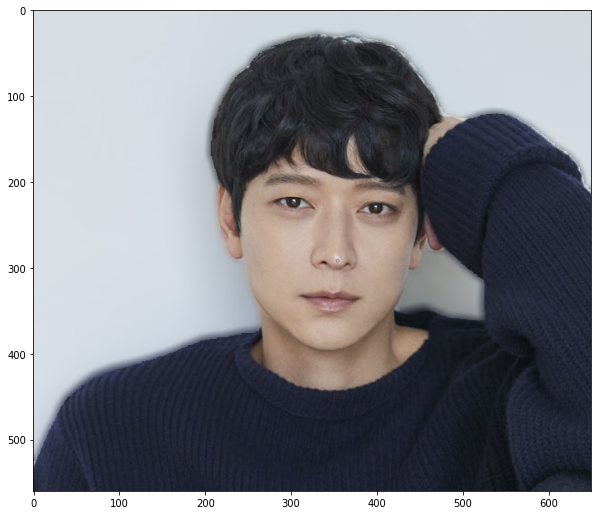

In [17]:
plt.figure(figsize=(10, 10))
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 블러 확인을 위해 사진 출력 크기를 키워봄
- 위의 사진에서는 블러 처리가 문제 없이 잘 된 것을 확인할 수 있음 

## 5. 고양이 사진 

(1440, 1080, 3)


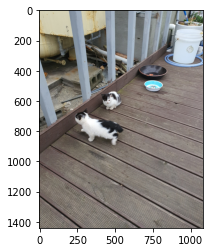

In [18]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_baby.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [20]:
segvalues, output = model.segmentAsPascalvoc(img_path)

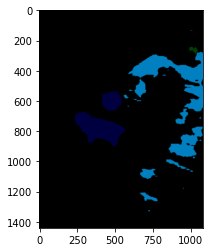

In [21]:
plt.imshow(output)
plt.show()

In [22]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [23]:
# cat은 8번째에 있음 
colormap[8]

array([64,  0,  0])

In [24]:
# output 이미지가 BGR 순서 -> RGB로 바꾸기 
seg_color = (0, 0, 64)

(1440, 1080)


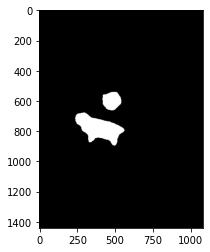

In [25]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

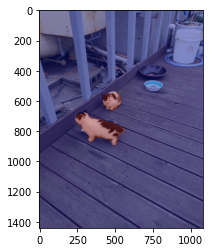

In [26]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

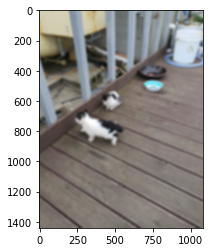

In [27]:
# 숫자가 커지면 블러 효과도 커짐 
img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

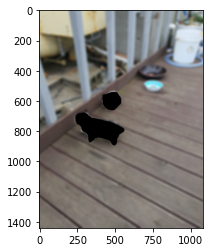

In [28]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

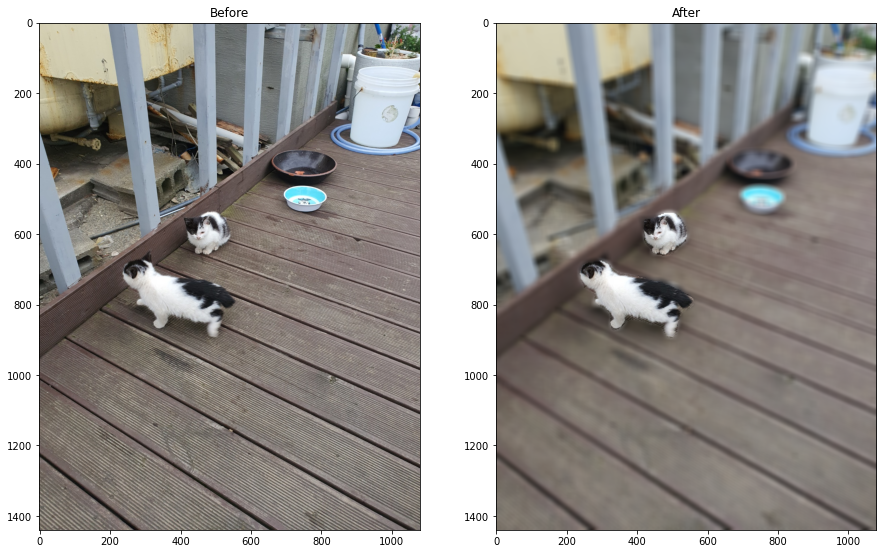

In [29]:
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Before')

plt.subplot(1,2,2)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('After')
plt.show()

In [30]:
from IPython.display import Image

- 마스크를 확인했을 때 검정색 2개로 고양이가 잘 분리된 것을 볼 수 있음
- 블러 처리 전 후를 확인했을 때 처음 블러 효과를 13으로만 했을때는 차이가 많이 나지 않아서 20로 올려서 다시 확인해봄
- 배경 부분이 확실히 흐릿해진 것을 볼 수 있음 


1) Gaussian Filter
- 현재 픽셀값과 주변 이웃 픽셀값들의 가중 평균(weighted average)을 이용해서 현재 픽셀의 값을 대체
- 현재 픽셀에서 가까울수록 더 큰 가중치를 갖고 멀수록 더 작은 가중치를 갖음
- 이미지는 공간적으로 천천히 변하기 때문에 가까이 있는 픽셀들은 비슷한 값들을 갖는다는 사실에 기반
- 엣지(edge)와 같이 공간적으로 급변하는 부분에서는 단점

2) Bilateral Filter
- Bilateral 필터는 엣지를 보존하면서 노이즈를 제거하는 비선형 필터
- 가중치는 현재 픽셀과 이웃하는 픽셀 사이의 유클리디안 거리 뿐만 아니라, radiometric 차이(예를 들어, 색깔 강도와 깊이 거리 등과 같은 range 차이들)와도 연관
- 현재 픽셀과 이웃하는 픽셀 사이의 거리와 픽셀값의 차이를 동시에 가중치에 반영
- 픽셀 사이의 거리만을 가중치에 반영하는 가우시안 필터의 좀 더 발전된 버전
- cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace,dst=None, borderType=None)
    - src: 입력 영상. 8비트 또는 실수형, 1채널 또는 3채널.
    - d: 필터링에 사용될 이웃 픽셀의 거리(지름), 음수(-1)를 입력하면 sigmaSpace 값에 의해 자동 결정(권장)
    - sigmaColor: 색 공간에서 필터의 표준 편차
    - sigmaSpace: 좌표 공간에서 필터의 표준 편차
    - dst: 출력 영상. src와 같은 크기, 같은 타입.
    - borderType: 가장자리 픽셀 처리 방식


## 문제점 찾기 1
- 고양이 귀 부분이 흐릿해진 것을 볼 수 있음 
- 가장자리 부분이 제대로 보존되지 않아서 귀 부분이 흐릿하게 보인 것 같다 
- 잡음 제거 효과가 좋으면서, 가장자리를 보존하는데 효과적인 Bilateral Filter 시도하기

![cat](cat_ear.png)
![cat_ear](https://user-images.githubusercontent.com/97458432/152357645-d8c1ef52-f253-49da-bbe3-ed15e5b902a1.png)


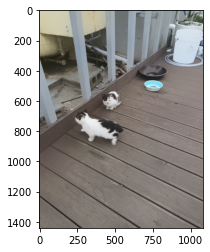

In [31]:
img_bilateral_blur = cv2.bilateralFilter(img_orig, -1, 75, 75)
plt.imshow(cv2.cvtColor(img_bilateral_blur, cv2.COLOR_BGR2RGB))
plt.show()

- bilateralFilter의 d 값을 -1로 설정하니 시간이 오래 걸리는 단점이 있음

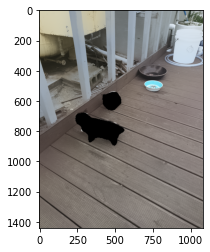

In [32]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_bilateral_blur = cv2.bitwise_and(img_bilateral_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_bilateral_blur, cv2.COLOR_BGR2RGB))
plt.show()

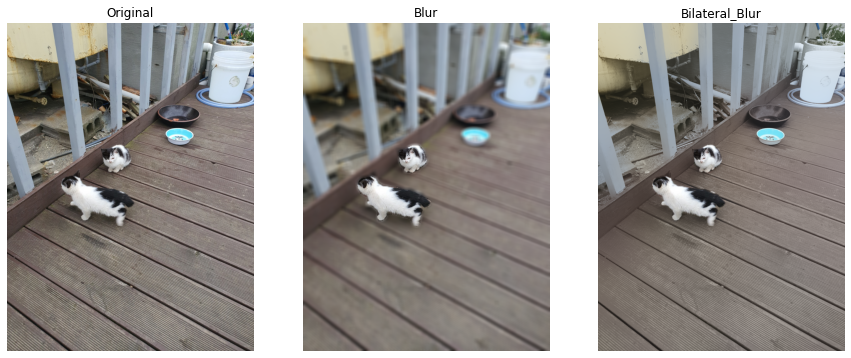

In [33]:
plt.figure(figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Blur')
plt.axis('off')

plt.subplot(1,3,3)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_bilateral_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('Bilateral_Blur')
plt.axis('off')

plt.show()

- 양방향 필터 사용 시 blur 효과는 적지만 고양이 귀 부분이 덜 뭉개지는 것을 볼 수 있다. 

## 6. 배경 합성하기 
#### 배경과 합성할 사진 가져오기

(177, 284, 3)


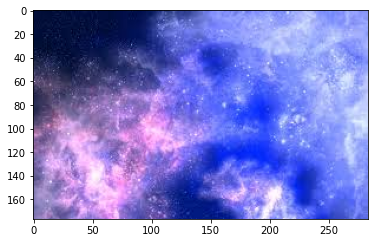

In [34]:
# 배경 사진 가져오기 
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/space.png'  
bg_img_orig = cv2.imread(bg_img_path) 
print(bg_img_orig.shape)

bg_img_rgb = cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(bg_img_rgb)
plt.show()

(720, 960, 3)


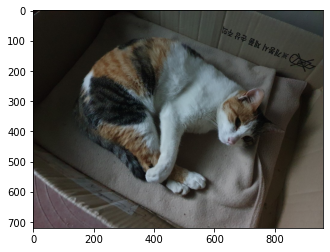

In [35]:
# 고양이 사진 가져오기 
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
cat_img_orig = cv2.imread(cat_img_path) 
print(cat_img_orig.shape)

cat_img_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cat_img_rgb)
plt.show()

In [36]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f466967d7f0>)

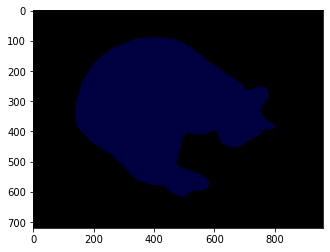

In [37]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(cat_img_path)

plt.imshow(output)
plt.show()

In [38]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

(720, 960)


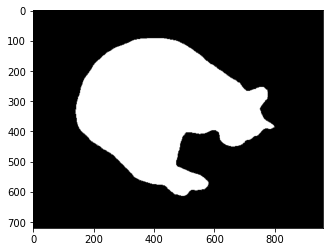

In [39]:
# colormap[8]    # array([64,  0,  0])
seg_color = (0, 0, 64)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

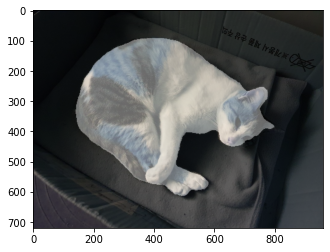

In [40]:
img_show = cat_img_rgb.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 기존 JET 말고 다른 것으로 바꿔봄, COLORMAP_BONE로 바꿔봄 
cat_color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_BONE )
img_show = cv2.addWeighted(img_show, 0.6, cat_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- ColormapTypes 종류가 많음
- 처음에는 winter로 바꾸고 아래 코드를 실행해보니 초록색 고양이에 빨간색 배경이 나왔고 그렇게 되면 아래 np.where 부분에서 색깔을 바꿔 넣어야 해서 그냥 흑백이 나오는 bone을 선택 

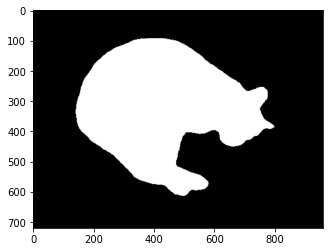

In [41]:
plt.imshow(cat_color_mask)

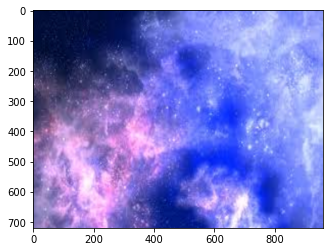

In [42]:
# 배경 이미지와 고양이 이미지 크기 맞추기
target_size = (cat_img_orig.shape[1], cat_img_orig.shape[0])
bg_resized = cv2.resize(bg_img_orig, target_size)  
# 아래 코드를 넣지 않으면 불그스름하게 나옴, RGB로 변환해야 원본 색깔이 나옴
bg_resized_rgb = cv2.cvtColor(bg_resized, cv2.COLOR_BGR2RGB)
plt.imshow(bg_resized_rgb)
plt.show()

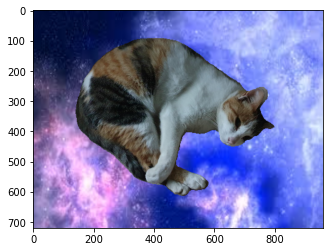

In [43]:
# img_concat = np.where(cat_color_mask==255, cat_img_orig, bg_resized)
# plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) 
# 위나 아래 코드 둘다 동일한 결과 나옴
img_concat = np.where(cat_color_mask==255, cat_img_rgb, bg_resized_rgb)
plt.imshow(img_concat)
plt.show()

rgb 변환된걸 또 변환해보면 어떻게 될지 궁금해서 해봄 

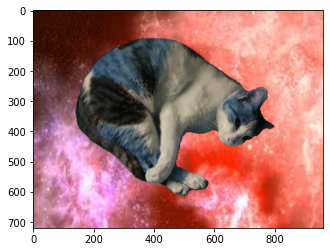

In [44]:
img_concat = np.where(cat_color_mask==255, cat_img_rgb, bg_resized_rgb)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

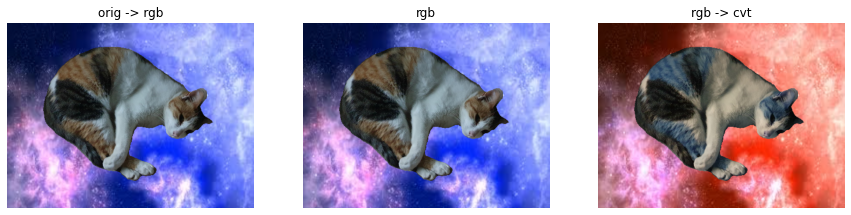

In [45]:
plt.figure(figsize=(15,15))

plt.subplot(131)
img_concat1 = np.where(cat_color_mask==255, cat_img_orig, bg_resized)
plt.imshow(cv2.cvtColor(img_concat1, cv2.COLOR_BGR2RGB))
plt.title('orig -> rgb')
plt.axis('off')


plt.subplot(132)
img_concat2 = np.where(cat_color_mask==255, cat_img_rgb, bg_resized_rgb)
plt.imshow(img_concat2)
plt.title('rgb')
plt.axis('off')


plt.subplot(133)
img_concat = np.where(cat_color_mask==255, cat_img_rgb, bg_resized_rgb)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('rgb -> cvt')
plt.axis('off')

plt.show()

- 원본 사진을 concat 후 BGR -> RGB로 변환하거나
- RGB로 변환된 사진을 바로 concat하는거나 똑같음!! 
- subplot 사용 시 , 없어도 되다니 더 쉬운 방법을 찾음
- plt.show()를 각 그래프 밑에 다 적으면 subplot이 적용되지 않아서 (3,1) 형식으로 사진이 출력됨 
- 모든 정보를 다 쓰고 맨 마지막에 plt.show()를 해야 제대로 적용됨 

### 고양이 스티커 만들기
- 원하는 위치에 고양이 사진 붙여보기 

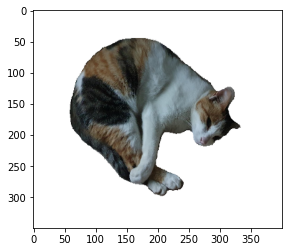

In [46]:
# 고양이 사진만 따로 잘라내기(400*350 사이즈로)
only_cat = np.where(cat_color_mask==255, cat_img_orig, 255)
only_cat = cv2.resize(only_cat, dsize=(400, 350), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(only_cat, cv2.COLOR_BGR2RGB))
plt.show()

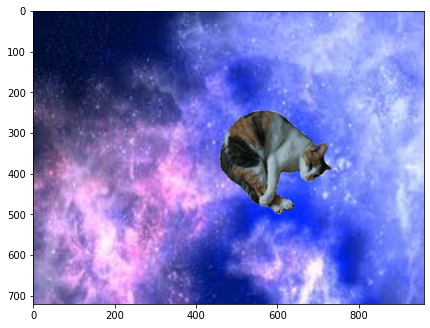

In [47]:
# 사진 위치지정 및 배경과 합성하기
refined_y = 200
refined_x = 400

sticker_area = bg_resized[refined_y:refined_y+only_cat.shape[0], refined_x:refined_x+only_cat.shape[1]]
bg_resized[refined_y:refined_y+only_cat.shape[0], refined_x:refined_x+only_cat.shape[1]] = np.where(only_cat==255,sticker_area,only_cat).astype(np.uint8)

plt.figure(figsize=(7, 7))
plt.imshow(cv2.cvtColor(bg_resized, cv2.COLOR_BGR2RGB))
plt.show()

## 다른 사진 불러와서 다시 해보기 
- 위에 했던 사진은 분리가 너무 잘 되어 따로 문제점이 없어서 사진 교체
- 얼굴이 가려져 있는 사진이라면 제대로 인식이 될까?

(161, 313, 3)


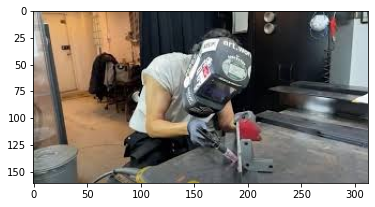

In [48]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/best2.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

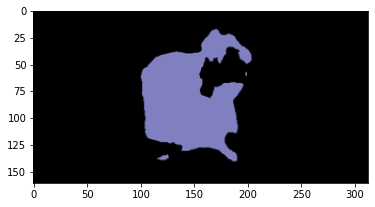

In [49]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show()

In [50]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[15]
seg_color = (128,128,192)

In [51]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)

(161, 313)


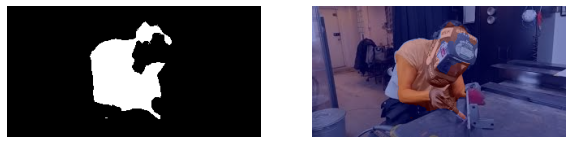

In [52]:
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(seg_map, cmap='gray')
plt.axis('off')

plt.subplot(122)
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

## 문제점 찾기 2
- 얼굴이 가려져 있어서 인식하지 못함
- 상체와 팔까지만 인식이 되고 몸통과 하체는 인식하지 못함

### 문제점 해결하기
- 시간 관계상 여기까지.... 설날을 너무 잘 보내고 옴 

## **Reference**
- 코드 참고 [hyyoo3526님 깃허브](https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_08/EXPLORATION_IC1_08_human_segmentation%20.ipynb)
- OpenCV 참고 
    - [1. 각 필터별 코드](http://www.gisdeveloper.co.kr/?p=6520)
    - [2. 각 필터별 차이점](https://bskyvision.com/24)
- [Google AI Blog](https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)